# Modelo Predador-Presa

Hay varias formas de representar el modelo predador-presa, una de ellas es mediante ecuaciones diferenciales: si hay demasiadas presas aumenta la cantidad de depredadores disminuyendo la población de presas pero si se reduce demasiado la población de presas la cantidad de depredadores también se reduce a un nivel mínimo y la población de presas vuelve a resurgir.

Este modelo fue inspirado por el video de un [leopardo contra una manada de babuinos](https://youtu.be/p5wnKEXs6YM?si=nJCllcA2APhTiBO8) donde el leopardo intenta atacar a un babuino pero su manada responde atacando al leopardo y este termina retirándose ante la multitud de babuinos.

## Reglas

En el modelo de predador-presa se compara la población de babuinos con la población de leopardos. Al momento de generar el tablero no hay huecos vacíos o animales muertos, la probabilidad de que un animal sea un babuino es del 40% y 60% para un leopardo.

En esta simulación los leopardos se caracterizan por atacar a los babuinos, si solo es un leopardo atacando la manada de babuinos existe el riesgo de que la manada sea muy grande y maten al leopardo, pero si es más de un leopardo en la caza los babuinos no pueden protegerse sin importar el tamaño del grupo.

En cambio los babuinos deben defenderse de las amenazas (leopardos), son capaces de formar grupos más grandes sin pelearse con una capacidad de reproducción mayor lo que representa ua ventaja para la supervivencia de la especie.

Las reglas que definen las leyes de predador-presa son las siguientes:
* **Si el agente actual es un babuino**:
    * Si hay un solo leopardo en la vecindad los babuinos serán atacados:
        * Si hay más de 3 babuinos en total el leopardo muere en el ataque y el babuino actual sobrevive.
        * Si hay 3 babuinos o menos el leopardo mata al babuino actual.
    * Si hay más de un leopardo en la vecindad los babuinos serán atacados:
        * La cantidad de babuinos matados es igual a la cantidad de leopardos o si hay menos babuinos que leopardos se matan a todos los babuinos.
    * Si no hay ningún leopardo en la vecindad:
        * Si la cantidad de babuinos en la vecindad es mayor a 5 se mata al babuino actual por sobrepoblación.
* **Si el agente actual es un leopardo**:
    * Si hay al menos un babuino en la vecindad:
        * Si no hay ningún leopardo en la vecindad el leopardo ataca a un babuino:
            * Si hay 3 babuinos o menos el leopardo mata a uno de ellos y sobrevive.
            * Si hay más de 3 babuinos el leopardo actual muere en el ataque.
        * Si hay otro o más leopardos en la vecindad:
            * Atacan a los babuinos, la cantidad de presas muertas es igual a la cantidad de leopardos o si hay menos presas que leopardos se matan a todas las presas de la vecindad.
    * Si no hay ningún babuino en la vecindad:
        * Si la cantidad de leopardos es mayor a 3 hay un conflicto por el dominio del grupo y el leopardo actual muere.
* **Si el agente actual es un espacioo vacío**:
    * Si no hay ningún leopardo y hay al menos 2 babuinos pero menos de 6 nace un nuevo babuino en la manada.
    * Si no hay ningún babuino y hay al menos 2 leopardos pero menos de 4 nace un nuevo leopardo en la manada.

In [ ]:
!python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [ ]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
# 'MultiGrid' pone varios objetos en una misma celda
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
# parametros de la estetica de la grafica
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [ ]:
class GameLifeAgent(Agent):
    """
    Representa a un agente o una celda con estado vivo (1) o muerto (0)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 1, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)

        # al inicio la proporcion de babuinos es mayor a la de leopardos
        # 0 = babuino - probabilidad del 60%
        # 1 = leopardo - probabilidad del 40%
        # 2 = animal muerto o hueco vacio - al prinipio ningun animal esta muerto ni hay huecos vacios

        # la probabilidad inicial de los babuinos es d
        self.live = np.random.choice(np.arange(0, 2), p=[0.4, 0.6])
        self.next_state = None

    def step(self):
        """
        Este método es el que calcula si la celda vivirá o morirá dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos, # posicion del agente en la celda, es inherente del framework no es un atributo declarado manualmetne en la clase
            moore=True, # incluye las esquinas de la cuadricula de los vecinos de la celula actual
            include_center=False)

        # live_neighbours = np.sum([neighbour.live for neighbour in neighbours])
        # el siguiente bloque es el programa o "razonamiento" del agente
        # buscar la cantidad de babuinos y leopardos vecinos
        n_baboon_neighbors = 0
        baboon_neighbors = []
        n_leopard_neighbors = 0
        leopard_neighbors = []
        n_empty_blocks = 0
        empty_blocks = []
        for neighbor in neighbours:
            if neighbor.live == 0: # el vecino es un babuino
                n_baboon_neighbors += 1
                baboon_neighbors.append(neighbor)
            elif neighbor.live == 1: # el vecino es un leopardo
                n_leopard_neighbors += 1
                leopard_neighbors.append(neighbor)
            elif neighbor.live == 2: # el vecino es un bloque vacio
                n_empty_blocks += 1
                empty_blocks.append(neighbor)

        if self.live == 0: # si el animal es un babuino sucede lo siguiente
            n_baboon_neighbors += 1 # agregando el babuino actual
            if n_leopard_neighbors == 1:
                # si hay al menos un leopardo se decide si muere el leopardo o babuino
                if n_baboon_neighbors > 3:
                    # el leopardo muere y el babuino actual continua vivo
                    leopard = leopard_neighbors[0]
                    leopard.next_state = 2
                    self.next_state = 0
                else:
                    # el babuino actual muere
                    self.next_state = 2
            elif n_leopard_neighbors > 1:
                # si hay mas de un leopardo la cantidad de babuinos muertos es igual a la cantidad de leopardos
                self.next_state = 2
                dead_baboons = 1 # ya se mato al babuino actual
                index = 0
                while dead_baboons < n_leopard_neighbors and dead_baboons < n_baboon_neighbors:
                    baboon_neighbors[index].next_state = 2
                    dead_baboons += 1
            elif n_leopard_neighbors == 0:
                # si no hay ningun leopardo en la vecindad puede ocurrir un conflicto entre los babuinos
                if n_baboon_neighbors > 5:
                    self.next_state = 2
        elif self.live == 1: # si el animal es un leopardo sucede lo siguiente
            n_leopard_neighbors += 1 # agregando al leopardo actual
            if n_baboon_neighbors >= 1:
                # si hay al menos un babuino cerca el leopardo ataca
                if n_leopard_neighbors >= 2:
                    # si hay en la vecindad al menos otro leopardo la cantidad de babuinos muertos es igual a la cantidad de leopardos
                    dead_baboons = 0
                    index = 0
                    while dead_baboons < n_leopard_neighbors and dead_baboons < n_baboon_neighbors:
                        baboon_neighbors[index].next_state = 2
                        dead_baboons += 1
                    self.next_state = 1 # el leopardo sigue vivo
                elif n_leopard_neighbors == 0:
                    # si no hay ningun leopardo cerca se decide si el leopardo vive o muere
                    if n_baboon_neighbors >= 4:
                        # el leopardo actual muere
                        self.next_state = 2
                else:
                    # el babuino muere y el leopardo actual sigue vivo
                    baboon = baboon_neighbors[0]
                    baboon.next_state = 2
                    self.next_state = 1
            elif n_baboon_neighbors == 0:
                # si no hay ningun babuino en la vecindad sucede lo siguiente
                if n_leopard_neighbors > 3:
                    # si hay 4 o mas leopardos el actual se muere por una guerra de control
                    self.next_state = 2
        elif self.live == 2:
            # si hay un hueco vacio y sucede lo siguiente
            if n_baboon_neighbors >= 2 and n_baboon_neighbors < 6 and n_leopard_neighbors == 0:
                # si hay una poblacion estable de babuinos y ningun leopardo cerca nace un nuevo babuino
                self.next_state = 0
            elif n_leopard_neighbors >= 2 and n_leopard_neighbors < 4 and n_baboon_neighbors == 0:
                # si hay una poblacion estable de leopardos y ningun babuino cerca nace un nuevo leopardo
                self.next_state = 1

    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state

class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        # el constructor le da forma la tablero
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        # el numero de agentes a usar es igual al numero de celdas del tablero
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True) # el True es de torus
        self.schedule = SimultaneousActivation(self) # genera una lista de tareas

        # se importa arriba: import random
        # celdas = model.grid.coord_iter()
        # celdas_con_arboles = random.sample(celdas, k=25)
        # posiciones_arboles = [pos for _, pos in celdas_con_arboles]

        # coord_iter devuelve todos los iterables de la celda (coordenadas del grid)
        for (content, pos) in self.grid.coord_iter():
            # if pos in posiciones_arboles
                # código para instanciar árbol

            a = GameLifeAgent(pos, self) # instanciamos un agente de la vida unico, el self es porque esta clase es el Modelo
            self.grid.place_agent(a, pos) # falta ubicar el nuevo agente en una posicion especifica
            self.schedule.add(a) # agregar el nuevo agente a la lista de tareas que se corre en cada step del Modelo

        # Aquí definimos el colector de datos para obtener el grid completo.
        # cada vez que se ejecuta un step recolecta las variables grid y live, son los "reporteros" o "periodistas"
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "BaboonsAlive": self.get_baboons_alive,
                             "LeopardsAlive": self.get_leopards_alive,
                             "EmptySpaces": self.get_empty_spaces}
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.live

        return grid

    def get_baboons_alive(self):
        """
        Devuelve la cantidad de babuinos vivos
        """

        baboons_alive = 0
        for baboon in model.grid.coord_iter():
            agent, _ = baboon
            if isinstance(agent, GameLifeAgent):
                if agent.live == 0: # el agente es un babuino
                    baboons_alive += 1

        return baboons_alive

    def get_leopards_alive(self):
        """
        Devuelve la cantidad de leopardos vivos
        """
        leopards_alive = 0
        for leopard in model.grid.coord_iter():
            agent, _ = leopard
            if isinstance(agent, GameLifeAgent):
                if agent.live == 1: # el agente es un leopardo
                    leopards_alive += 1

        return leopards_alive

    def get_empty_spaces(self):
        """
        Devuelve la cantidad de espacios vacios o animales muertos
        """
        empty_spaces = 0
        for space in model.grid.coord_iter():
            agent, _ = space
            if isinstance(agent, GameLifeAgent):
                if agent.live == 2: # el agente es un espacio vacio
                    empty_spaces += 1

        return empty_spaces


# Ejecución del modelo

Ya se creó el modelo, a continuación lo corremos

El número de generaciones es el número de steps o el número de iteraciones por las que pasa el algoritmo.

1 step = 1 generación = 1 iteración

In [ ]:
# Cantidad de agentes: tamanio del grid (NxN)

# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 150

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

# ====================================================================================
# Todo el problema se reduce a estas 3 lineas donde se hace instancia del
# modelo creado previamente y se ejecuta por X generaciones
model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
# ====================================================================================

final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:14.585022


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [ ]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [ ]:
all_grids

,Grid,BaboonsAlive,LeopardsAlive,EmptySpaces
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0,...",4045,5955,0
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0,...",4,5850,4146
2,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",5,1046,8949
3,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",5,1739,8256
4,"[[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",7,2691,7302
...,...,...,...,...
145,"[[2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0,...",599,3210,6191
146,"[[0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0,...",582,2961,6457
147,"[[2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0,...",612,3148,6240
148,"[[2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0,...",601,2953,6446


In [ ]:
# Todas estas lineas son solo para animar y agregar colores en la grafica

%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

# si quiero graficar mas de 2 agentes entonces debo agregar mas de 2 colores en estas lineas
colors = [] # colores en formato RGB
colors.append(np.array([31 / 255, 229 / 255, 242 / 255, 1])) # azul - 0 - manada de babuinos
colors.append(np.array([255 / 255, 80 / 255, 80 / 255, 1])) # rojo - 1 - manada de leopardos
colors.append(np.array([0, 0, 0, 1])) # negro - 2 - zona muerta
colormap = mlp.colors.ListedColormap(colors)

# en este ejemplo la cantidad de agentes va de 0 a 1 (2 agentes), si quiero agregar mas agentes
# debo extender ese limite establecido de 0 a n-1 donde n es el numero de agentes
patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=2)

baboons_alive = []
leopards_alive = []
empty_spaces = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])
    baboons_alive.append(all_grids['BaboonsAlive'].iloc[i])
    leopards_alive.append(all_grids['LeopardsAlive'].iloc[i])
    empty_spaces.append(all_grids['EmptySpaces'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [ ]:
anim

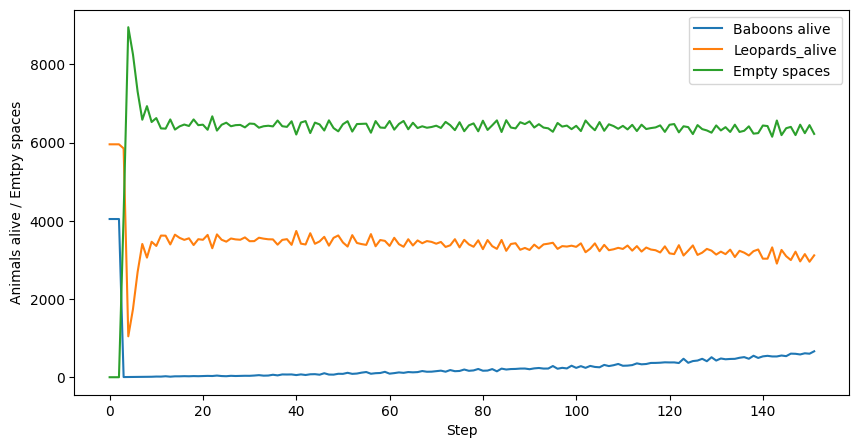

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Animals alive / Emtpy spaces")

plt.plot(baboons_alive, label="Baboons alive")
plt.plot(leopards_alive, label="Leopards_alive")
plt.plot(empty_spaces, label="Empty spaces")
plt.legend()
plt.show()

# Batch simulation

In [ ]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], baboons_alive=[], leopards_alive=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['baboons_alive'].append(all_grids['BaboonsAlive'].to_numpy())
    batch_data['leopards_alive'].append(all_grids['LeopardsAlive'].to_numpy())


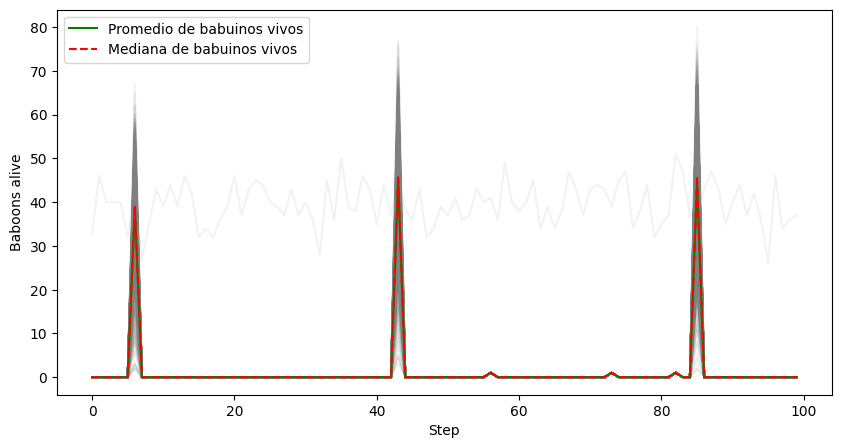

In [138]:
# Las lineas grises son de todas las iteraciones anteriores

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Baboons alive")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['baboons_alive'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['baboons_alive']), axis=1), color='Green', label='Promedio de babuinos vivos') # promedio
plt.plot(np.median(np.array(batch_data['baboons_alive']), axis=1), color='Red', linestyle='dashed', label='Mediana de babuinos vivos') # mediana
plt.legend()

plt.show()

En la gráfica se observa que la población de babuinos vivos aumenta y disminuye en los mismos periodos pero la razón de incremento varía en esos periodos, a veces es mayor pero a veces es menor.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


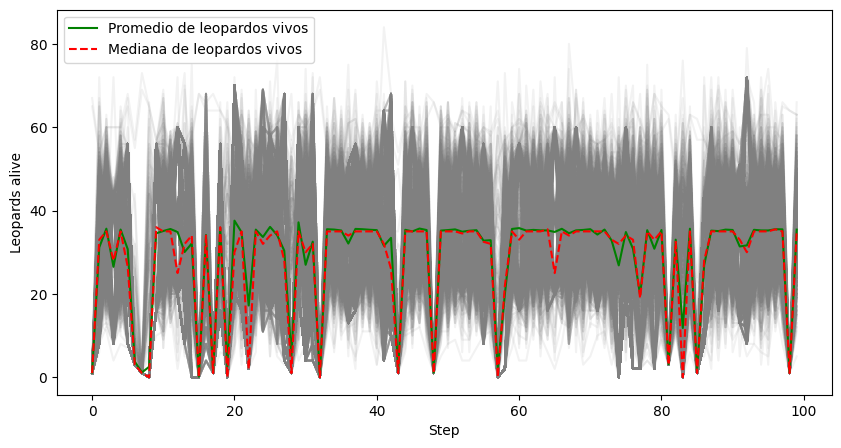

In [139]:
# Las lineas grises son de todas las iteraciones anteriores

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Leopards alive")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['leopards_alive'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['leopards_alive']), axis=1), color='Green', label='Promedio de leopardos vivos') # promedio
plt.plot(np.median(np.array(batch_data['leopards_alive']), axis=1), color='Red', linestyle='dashed', label='Mediana de leopardos vivos') # mediana
plt.legend()

plt.show()

En la gráfica se observa que la población de leopardos varía entre periodos pero al ver el promedio y mediana se determina que hay una zona de estabilidad común entre la mayoría de las ejecuciones.